In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import glob, os
from statsmodels.graphics.gofplots import qqplot
from numpy.random import seed
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import plotly.express as px




## Functıons 

In [34]:
pd.options.plotting.backend="plotly"

In [35]:
# Function to extract float values from a string in the format "[x,y,z]"
def get_float_values(string):  
    #289, 582]
    #289, 582
    # ['289', ' 582']
    value_str = string.split('[')[1].split(']')[0].split(",")  # [1 2 3]
    value_str0 = value_str[0] 
    if len(value_str)>=2: 
        value_str1 = value_str[1].strip()  
    else:
        value_str1 = '0' 
    return [float(value_str0), float(value_str1)]

# Function to analyze response times data and calculate various statistics
def analyze_response_times(df, false_alarm_threshold=200, miss_threshold=500):
    # Extract float values from the 'Response Times' column of the DataFrame
    aPVTList = [get_float_values(string) for string in df['Response Times'].values] #[1, 2, ...]
    aPVT = [] 
    
    # Create a new column 'Classification' to classify each trial
    df['Classification'] = 'Hit'  # Assume all trials are hits by default
    
    for i, response_times in enumerate(aPVTList): 
        if response_times is None:
            df.at[i, 'Classification'] = 'Lapse'
            aPVT.append(0) 
        else:
            rt = response_times            
            aPVT.append(response_times[0])
            
            if int(response_times[-1]) > 0:  
                if min(response_times) < false_alarm_threshold:
                     df.at[i, 'Classification'] = 'False Alarm' 
                elif  max(response_times)> miss_threshold:
                     df.at[i, 'Classification'] = 'Miss False Alarm' 
                else:
                     df.at[i, 'Classification'] = 'False Alarm'

            else:
                if aPVT[i]< false_alarm_threshold:
                     df.at[i, 'Classification'] = 'False Alarm' 
                elif aPVT[i] > miss_threshold:
                     df.at[i, 'Classification'] = 'Miss' 

           
    # Convert the 'Timestamp' column to datetime objects if it's not already
    df['Timestamps'] = pd.to_datetime(df['Timestamps'])

    # Calculate time elapsed in minutes and store it in a new column 'TimeMinutes'
    df['TimeMinutes'] = (df['Timestamps'] - df['Timestamps'].iloc[0]).dt.total_seconds() / 60.0 
    # Filter out false alarms and misses from the 'aPVT' list
    correct_responses = [rt for rt in aPVT if isinstance(rt, float) and false_alarm_threshold <= rt <= miss_threshold]

    # Calculate mean, median, and standard deviation of response times
    mean_rt = np.mean(correct_responses)
    median_rt = np.median(correct_responses)
    std_rt = np.std(correct_responses)
    
    # Calculate effective size (eff_size) using a fixed value of 4
    eff_size = (mean_rt - 4) / std_rt
    eff_size_median = (median_rt - 4) / std_rt
    
    # Sort reaction times in ascending order
    sorted_reaction_times = sorted(correct_responses)
    
    # Calculate the number of elements to take from the sorted list (10% of total elements)
    n = round(len(sorted_reaction_times) * 0.1)
    
    # Get the fastest 10% of reaction times
    fastest_10_percent = sorted_reaction_times[:n]
    
    # Sort the reaction times in ascending order
    sorted_reaction_times = sorted(correct_responses)
    # Calculate the number of elements corresponding to the slowest 10%
    n = int(0.1 * len(sorted_reaction_times))
    # Get the slowest 10% of reaction times using negative indexing
    slowest_10_percent = sorted_reaction_times[-n:] 
    
    
    # Return all calculated statistics and lists of fastest and slowest reaction times
    return mean_rt, median_rt, std_rt, eff_size, fastest_10_percent, slowest_10_percent,df['Classification']

# function to write processed data
def writeProcessedData(df, name, classification):
    nameStart = name.split('/')[1].split('\\')
    _filename = nameStart[0].split('_')[1] +'.xlsx'
    _sheet_name =nameStart[1].split('_')[0]  

    dic_ = {'Times': pd.to_datetime(df['Timestamps']).values,
            'Interval to next sound_s':df['Interval to next sound_s'].values,
            'Keys pressed':[get_float_values(string) for string in df['Keys pressed'].values],
            'Response Times':[get_float_values(string) for string in df['Response Times'].values],
            "Classification": classification.values}
    dfs = pd.DataFrame(dic_)
        
    try:
        with pd.ExcelWriter(_filename, engine='openpyxl', mode='a') as writer:
            try :
                dfs.to_excel(writer, sheet_name=_sheet_name)
            except ValueError:
                pass
    except FileNotFoundError:
        dfs.to_excel(_filename, sheet_name=_sheet_name)

# Main function to process data from CSV files
def processData(filename, condition="Light"):
    # Initialize lists to store calculated statistics
    mean_00_10_aPVT = []
    median_00_10_aPVT = []
    std_00_10_aPVT = []
    eff_size_00_10_aPVT = []
    lapses = []
    alarms = []
    
    # Loop through the CSV files matching the given pattern
    for i, name in enumerate(glob.glob(filename, recursive=True)): 
        # Read data from the CSV file into a DataFrame
        df = pd.read_csv(name)
        # Count false alarms in the DataFrame and store the count in the 'alarms' list
        #alarms.append(get_false_alarm(df)) 
        
        # Count the number of rows where 'Response Times' column is empty and store the count in the 'lapses' list
        lapse = (df.values.ravel() == '[]').sum() 
        lapses.append(lapse)
        
        # Remove rows with empty 'Response Times' and reset the DataFrame index
        df = df[~(df == '[]').any(axis=1)]
        df.reset_index(drop=True, inplace=True)
                      
        #result_mean, result_median, result_std, result_eff_size, _, _, df_with_classifications = analyze_response_times(df)
        # Analyze the response times in the DataFrame and store the statistics in the respective lists
        mean_aPVT, median_aPVT, std_aPVT, eff_size_aPVT, fastest_10_percent, slowest_10_percent, classification = analyze_response_times(df)
        
        mean_00_10_aPVT.append(mean_aPVT)
        median_00_10_aPVT.append(median_aPVT)
        std_00_10_aPVT.append(std_aPVT)
        eff_size_00_10_aPVT.append(eff_size_aPVT)
        #
        writeProcessedData(df, name, classification)

    # Calculate the general mean of mean_00_10_aPVT list
    general_mean = np.mean(mean_00_10_aPVT)

    # Plot the mean response time for the 'condition'
    #myplot(data=mean_00_10_aPVT, condition=condition)
    
        
    return mean_00_10_aPVT, median_00_10_aPVT, std_00_10_aPVT, eff_size_00_10_aPVT


In [36]:

filename = "./aPVT_lightCondition/*.csv"
lc_data_mean, lc_data_median, lc_data_std, lc_mean_eff_size = processData(filename)

light_data = {
    ('Light condition', 'Mean'): lc_data_mean,
    ('Light condition', 'Median'): lc_data_median,
    ('Light condition', 'Standard Deviation'): lc_data_std,
    ('Light condition', 'Effective Size'): lc_mean_eff_size,

}

df1 = pd.DataFrame(light_data)
print(df1)


   Light condition                                         
              Mean Median Standard Deviation Effective Size
0       239.727273  240.0          20.519426      11.488005
1       312.540541  307.0          23.652432      13.044770
2       321.514286  321.0          23.201443      13.685110
3       338.542857  336.0          34.491691       9.699230
4       348.028571  343.0          28.497103      12.072405
5       342.384615  344.0          30.710906      11.018386
6       349.032258  337.0          35.302823       9.773503
7       346.550000  338.5          38.719472       8.846970
8       349.848485  341.0          32.359834      10.687585
9       358.800000  350.0          35.664949       9.948143
10      356.941176  350.5          38.188342       9.242118


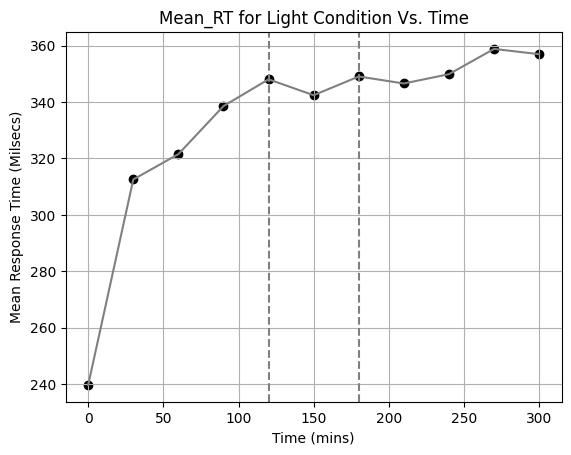

In [56]:
#  plot
#time = [i for i in range(11)]
time = [0,30,60,90,120,150,180,210,240,270,300]

# Define the x-coordinates for the vertical lines
vertical_lines = [120, 180]

# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')

#Light condition
#plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')
plt.plot(time, lc_data_mean, color='grey')
plt.scatter(time, lc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Light Condition Vs. Time')
plt.grid()
plt.show()


In [38]:
df1.to_csv('lightCondition.csv', index=False)

In [39]:
filename = "./aPVT_darkCondition/*.csv"
dc_data_mean, dc_data_median, dc_data_std, dc_data_eff_size = processData(filename, condition = "Dark")

dark_data = {
    ('Dark  condition', 'Mean'): dc_data_mean,
    ('Dark  condition', 'Median'): dc_data_median,
    ('Dark  condition', 'Standard Deviation'): dc_data_std,
    ('Dark  condition', 'Effective Size'): dc_data_eff_size
}

df2 = pd.DataFrame(dark_data)
print(df2)

   Dark  condition                                         
              Mean Median Standard Deviation Effective Size
0       238.351351  228.0          36.495254       6.421420
1       248.882353  248.0          22.513741      10.877018
2       251.885714  255.0          29.574865       8.381635
3       269.914286  270.0          23.746725      11.197935
4       273.081081  272.0          35.773596       7.521779
5       281.028571  280.0          28.430854       9.743941
6       311.818182  303.0          52.686871       5.842408
7       325.108108  312.0          52.511921       6.114956
8       322.818182  311.0          54.195748       5.882716
9       274.555556  273.0          26.927314      10.047625
10      309.594595  311.0          47.518110       6.431118


In [40]:
try:
    with pd.ExcelWriter("Stat_PVT_Results.xlsx", engine='openpyxl', mode='a') as writer:
        try :
            df2.to_excel(writer, sheet_name='Dark_Condition')
        except ValueError:
            pass
except FileNotFoundError:
    df1.to_excel("Stat_PVT_Results.xlsx", sheet_name="Light_Condition")

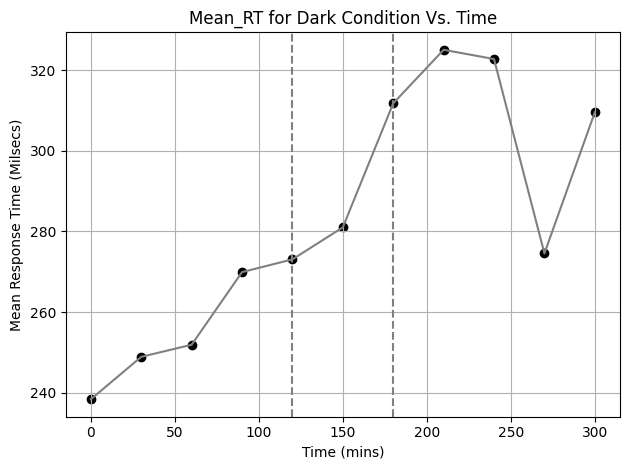

In [53]:
# Define the x-coordinates for the vertical lines
vertical_lines = [120, 180]

# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')
#Dark condition
#plt.style.use('fivethirtyeight')
plt.plot(time, dc_data_mean, color='grey')
plt.scatter(time, dc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Dark Condition Vs. Time')
plt.grid()
plt.tight_layout()
plt.show()


In [42]:
ReactionT_Result = pd.merge(df1, df2, left_index=True, right_index=True)
ReactionT_Result

Light condition                                          Dark  condition  \
              Mean Median Standard Deviation Effective Size            Mean   
0       239.727273  240.0          20.519426      11.488005      238.351351   
1       312.540541  307.0          23.652432      13.044770      248.882353   
2       321.514286  321.0          23.201443      13.685110      251.885714   
3       338.542857  336.0          34.491691       9.699230      269.914286   
4       348.028571  343.0          28.497103      12.072405      273.081081   
5       342.384615  344.0          30.710906      11.018386      281.028571   
6       349.032258  337.0          35.302823       9.773503      311.818182   
7       346.550000  338.5          38.719472       8.846970      325.108108   
8       349.848485  341.0          32.359834      10.687585      322.818182   
9       358.800000  350.0          35.664949       9.948143      274.555556   
10      356.941176  350.5          38.188342       9.242118      309.594595   

                                             
   Median Standard Deviation Effective Size  
0   228.0          36.495254       6.421420  
1   248.0          22.513741      10.877018  
2   255.0          29.574865       8.381635  
3   270.0          23.746725      11.197935  
4   272.0          35.773596       7.521779  
5   280.0          28.430854       9.743941  
6   303.0          52.686871       5.842408  
7   312.0          52.511921       6.114956  
8   311.0          54.195748       5.882716  
9   273.0          26.927314      10.047625  
10  311.0          47.518110       6.431118

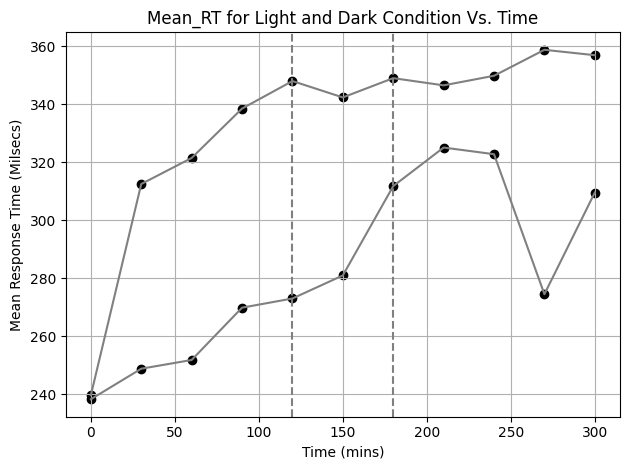

In [57]:

#Light condition
# Draw vertical lines
for line in vertical_lines:
    plt.axvline(x=line, color='grey', linestyle='--')
#Dark condition
#plt.style.use('ggplot')
plt.plot(time, dc_data_mean, color='grey')
plt.scatter(time, dc_data_mean, color='black', label='Points')
plt.plot(time, lc_data_mean, color='grey')
plt.scatter(time, lc_data_mean, color='black', label='Points')
plt.xlabel('Time (mins)')
plt.ylabel('Mean Response Time (Milsecs)')
plt.title('Mean_RT for Light and Dark Condition Vs. Time')
plt.grid()
plt.tight_layout()
plt.show()

In [44]:
#myplot(data = lc_data_mean,data2 = dc_data_mean, condition = "Light and Dark",_range = 11,combine_plot = True)

## Normality Test using Hist, Boxplot, and Shapiro Wilk Test

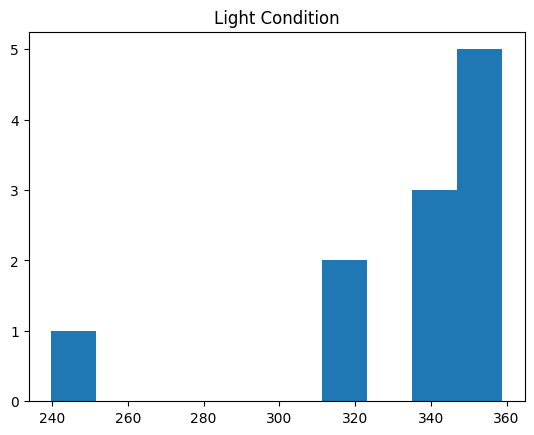

In [45]:
lc_data_mean = pd.DataFrame({'lc_data_mean': lc_data_mean})
plt.hist(lc_data_mean)
plt.title('Light Condition')
plt.show()


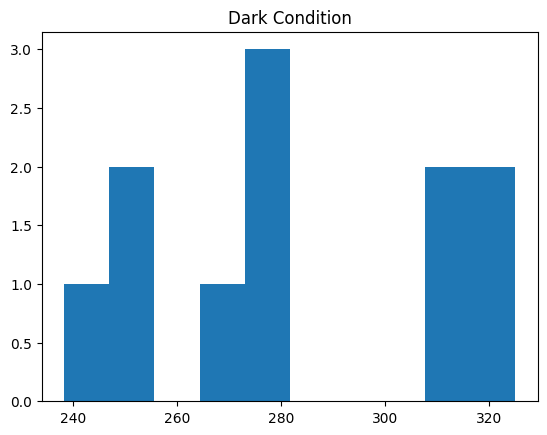

In [46]:
dc_data_mean = pd.DataFrame(dc_data_mean)
plt.hist(dc_data_mean)
plt.title('Dark Condition')
plt.show()

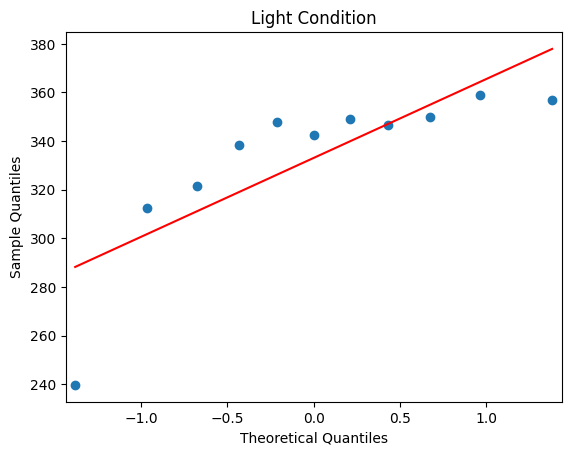

In [47]:
qqplot(lc_data_mean, line = 's')
plt.title('Light Condition')
plt.show()

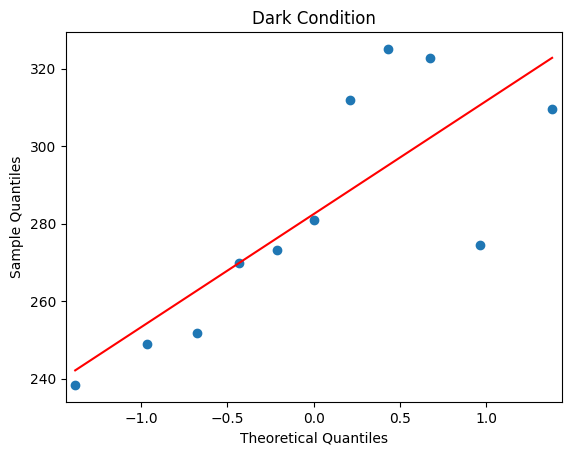

In [48]:
dc_data_mean = np.array(dc_data_mean)
qqplot(dc_data_mean, line = 's')
plt.title('Dark Condition')
plt.show()

In [49]:
#Normality test using Shapiro-Wilk Test for Light Condition
#normality Test
stat, p = shapiro(lc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
        

Statistics = 0.696, p = 0.000
Sample does not look Gaussian (reject H0)


In [50]:
#Normality test using Shapiro-Wilk Test for Dark Condition
#normality Test
stat, p = shapiro(dc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
        

Statistics = 0.921, p = 0.330
Sample looks Gaussian (fail to reject H0)


In [51]:
#After carrying out the normality test, the results showed that, the data
#are not normal; hence non-parametric test has to be done.

#Since the dark condition and light condition are independent, Mann Whitney U test is performed.
#Normality test using Shapiro-Wilk Test for Dark Condition
#normality Test
stat, p = mannwhitneyu(lc_data_mean,dc_data_mean)
print('Statistics = %.3f, p = %.3f' % (stat, p))
#interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics = 107.000, p = 0.003
Sample does not look Gaussian (reject H0)


C:\Users\ysogodok\AppData\Local\Temp\ipykernel_23240\3854971395.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Statistics = %.3f, p = %.3f' % (stat, p))


## Calculating the reciprocal of reaction time

In [52]:
# Assuming you have the following lists:
dfh_lc_dc = pd.DataFrame({
    'light_condition_data':lc_data_mean['lc_data_mean'].values,
    'dark_condition_data':[i[0] for i in dc_data_mean]
})

# Calculate 1/RT for light conditions and create a DataFrame
reciprocal_RT_light = 1000 / dfh_lc_dc['light_condition_data']
reciprocal_RT_light = reciprocal_RT_light.round(3)
reciprocal_RT_light.columns = ['reciprocal_RT_light']

# Calculate 1/RT for dark conditions and create a DataFrame
reciprocal_RT_dark = 1000 / dfh_lc_dc['dark_condition_data']
reciprocal_RT_dark = reciprocal_RT_dark.round(3)
reciprocal_RT_dark.columns = ['reciprocal_RT_dark']

# Merge the two DataFrames based on their indices
result_df = pd.merge(reciprocal_RT_light, reciprocal_RT_dark, left_index=True, right_index=True)
result_df


,light_condition_data,dark_condition_data
0,4.171,4.195
1,3.200,4.018
2,3.110,3.970
3,2.954,3.705
4,2.873,3.662
5,2.921,3.558
6,2.865,3.207
7,2.886,3.076
8,2.858,3.098
9,2.787,3.642
